In [9]:
import numpy as np
from collections import deque
from dd_class import Dragodinde
from dd_class import Elevage
import random
import time

In [10]:
# Define the structure for each object
class LinkGeneration:
    def __init__(self, color, generation, next_colors):
        self.color = color
        self.generation = generation
        self.next_colors = next_colors

    def __repr__(self):
        return f"color:{self.color}, generation:{self.generation}, next_colors:{self.next_colors})"

    # Getter for color
    def get_color(self):
        return self.color

    # Getter for generation
    def get_generation(self):
        return self.generation

    # Getter for next_colors
    def get_ancestor(self):
        return self.next_colors
    
# Define the list of objects (example data)
color_generation_list = [
    [
        LinkGeneration("Dorée", 1, []),
        LinkGeneration("Amande", 1, []),
        LinkGeneration("Rousse", 1, [])
    ],[
        LinkGeneration("Amande et Rousse", 2, ["Amande", "Rousse"]),
        LinkGeneration("Amande et Dorée", 2, ["Amande", "Dorée"]),
        LinkGeneration("Dorée et Rousse", 2, ["Dorée", "Rousse"])
    ],[
        LinkGeneration("Indigo", 3, ["Amande et Dorée", "Dorée et Rousse"]),
        LinkGeneration("Ebène", 3, ["Amande et Rousse", "Dorée et Rousse"])
    ],[
        LinkGeneration("Ebène et Indigo", 4, ["Ebène", "Indigo"]),
    ],[
        LinkGeneration("Pourpre", 5, ["Ebène et Indigo", "Indigo"]),
        LinkGeneration("Orchidée", 5, ["Ebène", "Ebène et Indigo"])
    ],[
        LinkGeneration("Ebène et Orchidée", 6, ["Ebène", "Orchidée"]),
        LinkGeneration("Orchidée et Pourpre", 6, ["Orchidée", "Pourpre"]),
        LinkGeneration("Indigo et Pourpre", 6, ["Indigo", "Pourpre"])
    ],[
        LinkGeneration("Ivoire", 7, ["Orchidée et Pourpre", "Indigo et Pourpre"]),
        LinkGeneration("Turquoise", 7, ["Ebène et Orchidée", "Orchidée et Pourpre"])
    ],[
        LinkGeneration("Turquoise et Orchidée", 8, ["Turquoise", "Orchidée"]),
        LinkGeneration("Ivoire et Turquoise", 8, ["Ivoire", "Turquoise"]),
        LinkGeneration("Ivoire et Pourpre", 8, ["Ivoire", "Pourpre"])
    ],[
        LinkGeneration("Emeraude", 9, ["Ivoire et Pourpre", "Ivoire et Turquoise"]),
        LinkGeneration("Prune", 9, ["Turquoise et Orchidée", "Ivoire et Turquoise"])
    ],[
        LinkGeneration("Prune et Emeraude", 10, ["Emeraude", "Prune"])
    ]
]

class Models :
    def __init__(self) :
        self.elevage = self.create_elevage()
        self.interred_dd = color_generation_list

    def __str__(self) :
        return (f"{self.elevage}")
    
    def get_length_elevage(self) :
        return len(self.elevage.get_dragodindes())
    
    def get_better_generation(self) :
        better_generation = 1
        for dragodinde in self.elevage.get_dragodindes() :
            generation = dragodinde.get_generation()
            if generation > better_generation :
                better_generation = generation
        
        return better_generation

    def get_dd_better_generation(self, dragodindes) :
        better_generation = 1
        list_better_dd = []
        for idx, dragodinde in enumerate(dragodindes) :
            generation  = dragodinde.get_generation()
            if generation > better_generation :
                list_better_dd = []
                better_generation = generation
                list_better_dd.append(dragodindes[idx])
            elif generation == better_generation :
                list_better_dd.append(dragodindes[idx])

        return list_better_dd

    def create_elevage(self):

        dragodindes_data = [
            (1, "M", "Rousse", 1),
            (2, "F", "Rousse", 1),
            (3, "M", "Amande", 1),
            (4, "F", "Amande", 1),
            (5, "M", "Dorée", 1),
            (6, "F", "Dorée", 1)
        ]

        list_dd = []
        for id, gender, color, generation in dragodindes_data:
            dragodinde = Dragodinde(id, gender, color, generation)
            list_dd.append(dragodinde)

        return Elevage(list_dd)
    
    def strategy_random_crosing(self):
        males = [dd for dd in self.elevage.get_dragodindes() if dd.get_sex() == "M"]
        females = [dd for dd in self.elevage.get_dragodindes() if dd.get_sex() == "F"]

        if not males or not females:
            raise ValueError("No suitable pairs for crossing.")

        male = random.choice(males)
        female = random.choice(females)

        # Assuming accouplement_naissance is a method that performs crossing and returns probabilities
        nouvelle_dd, _ = self.elevage.accouplement_naissance(male, female)

        return nouvelle_dd
    
    def strategy_crosing_better_gen(self):
        males = [dd for dd in self.elevage.get_dragodindes() if dd.get_sex() == "M"]
        females = [dd for dd in self.elevage.get_dragodindes() if dd.get_sex() == "F"]

        if not males or not females:
            raise ValueError("No suitable pairs for crossing.")

        # Take the best generation
        list_better_males = self.get_dd_better_generation(males)
        list_better_females = self.get_dd_better_generation(females)

        if list_better_males[0].get_generation() > list_better_females[0].get_generation():
            male = random.choice(males)
            female = random.choice(list_better_females)
        
        elif list_better_males[0].get_generation() <= list_better_females[0].get_generation():
            male = random.choice(list_better_males)
            female = random.choice(females)

        nouvelle_dd, _ = self.elevage.accouplement_naissance(male, female)
        return nouvelle_dd

    def is_in_every_sublist(self, lst, target):
        for item in lst:
            if isinstance(item, list):
                if not self.is_in_every_sublist(item, target):  # Recursively check sublists
                    return False
            elif item != target:
                return False
        return True
    
    # List the quality of purety of a list of dd
    def check_purity(self, list_dd : list, purity=3) -> list :
        """
        Purity : Thresold of purity (same color) quality
        (0 : only ind is pur, 1 : ind + parent, ...)
        """
        list_pur = []        
        for dd in list_dd :
            list_color_dd = dd.get_arbre_genealogique().get_genealogie(purity)
            color_ind = dd.get_color()

            # Case no genealogie or not all generation present
            if not list_color_dd or self.is_in_every_sublist(list_color_dd, color_ind) : 
                list_pur.append(dd)

        return list_pur
    
    def possible_new_generation_creation(self, color_level: list, color_pure_males: list, color_pure_females: list) -> list:

        breeding_indices = []

        # Iterate through the color_level list
        for i in range(len(color_level)):
            for j in range(len(color_level)):
                if i != j :
                    breeding_indices.append((i, j))

        print("breeding_indices : ", breeding_indices)
        return breeding_indices
    
    def create_new_generation(self, list_breeding) :
        return ""

    def identify_crosing(self, males, females, pure_males, pure_females, 
                          color_males, color_females, color_pure_males, 
                          color_pure_females):
        target_generation = 9  # The final generation we want to achieve
        male = None
        female = None

        # Start by checking from the last generation that needs to be achieved
        for gen in range(target_generation, 1, -1):
            color_level = [generation.get_color() for generation in self.interred_dd[gen]]
            color_ancestor = [generation.get_ancestor() for generation in self.interred_dd[gen]]
            print("color_ancestor : ", color_ancestor)
            
            # Case 1 : generation are not present but the ancestor are pure and we can create new generation
            if (color_level not in pure_males and color_level not in pure_females) \
                and (self.interred_dd[gen]) :
                list_breeding = self.possible_new_generation_creation(color_level, color_pure_males, color_pure_females)
                self.create_new_generation(list_breeding)
            
            # Case 2 : generation are present but not pure and need to be purify
            elif ... :
                
                if (color_level not in pure_males) and (color_level not in pure_females) :
                    # Try to 
                    pass
                    #if 

            # Case 3 : generation are not presente and ancestor aren't pur 
            else : 
                continue

        raise ValueError("male and female not paired in indentify_dd()")

    def strategy_select_and_purify(self) :
        # Intuition:
        # Identify dd that need to be crossed to create a 10th-generation dd
        # Identify dd that need to be purified (while the n-1 generation dd is available)
        # Purify and lock the selected dd (M and F)
        # While a selected dd is identified (color) and gen n - 1 is purified
        # Do crossing / purification step   

        males = [dd for dd in self.elevage.get_dragodindes() if dd.get_sex() == "M"]
        females = [dd for dd in self.elevage.get_dragodindes() if dd.get_sex() == "F"]
        color_males = [dd.get_color() for dd in males]
        color_females = [dd.get_color() for dd in females]

        # check if male and female are pure 
        pure_males = self.check_purity(males)
        pure_females = self.check_purity(females)
        color_pure_males = [dd.get_color() for dd in pure_females]
        color_pure_females = [dd.get_color() for dd in pure_females]

        # Identify dd that need to be created of purify 
        male, female = self.identify_crosing(males, females, pure_males, \
                                        pure_females, color_males, \
                                        color_females, color_pure_males, \
                                        color_pure_females)
        
        print("male, female : ", male.get_color(), female.get_color())

        # Crossing each other
        nouvelle_dd, _ = self.elevage.accouplement_naissance(male, female)
        print("new born : ", nouvelle_dd.get_color())
        return nouvelle_dd
    
import matplotlib.pyplot as plt
 
def plot_simlation(list_simulation) : 
    x_values = list(range(len(list_simulation)))

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plotting the two lists
    plt.plot(x_values, list_simulation, label='Generation List', color='blue')
    plt.ylim(0, 11)

    # Adding labels and title
    plt.xlabel('Number of Croisement')
    plt.ylabel('Generation Number')
    plt.title('Plot of Generation Numbers per Croisement')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

## Model 1 : random crosing

In [11]:
elevage = Models()
list_random = [1]
better_generation = 1
crosing_number = 1000
for i in range(crosing_number) :
    new_dd = elevage.strategy_random_crosing()
    generation = new_dd.get_generation()
    if generation > better_generation :
        better_generation = generation
    list_random.append(better_generation)

## Model 2 : Best generation crosing

In [12]:
elevage = Models()
better_generation = 1
list_gen_upgrade_random = [1]
crosing_number = 1000
for i in range(crosing_number) :
    new_dd = elevage.strategy_crosing_better_gen()
    generation = new_dd.get_generation()
    if generation > better_generation :
        better_generation = generation
    list_gen_upgrade_random.append(better_generation)

## Model 3 : Select and purify crosing

In [13]:
# elevage = Models()
# better_generation = 1
# list_select_purify = [1]
# crosing_number = 1000
# for i in range(crosing_number) :
#     new_dd = elevage.strategy_select_and_purify()
#     generation = new_dd.get_generation()
#     if generation > better_generation :
#         better_generation = generation
#     list_select_purify.append(better_generation)

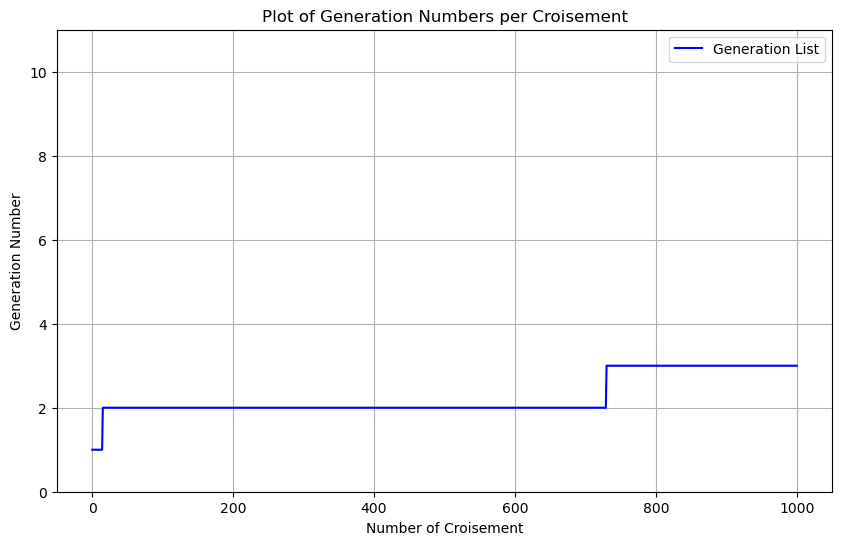

In [14]:
plot_simlation(list_random) 

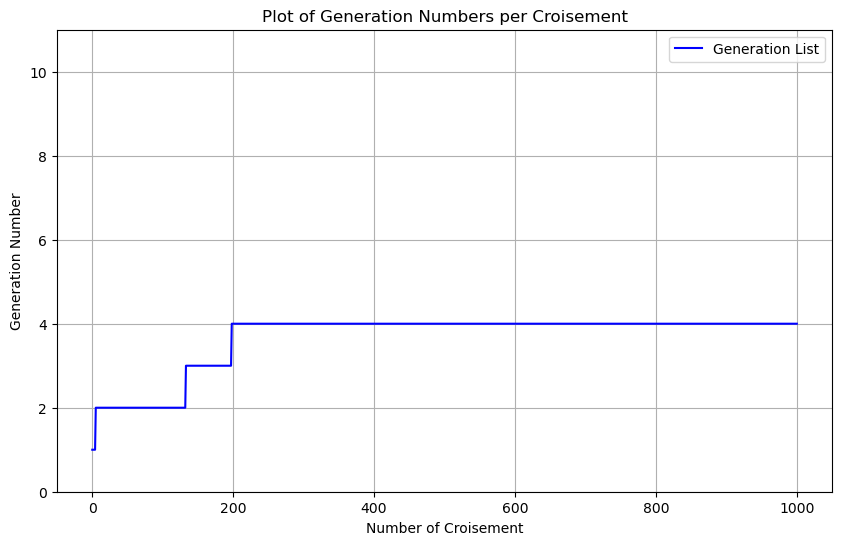

In [15]:
plot_simlation(list_gen_upgrade_random) 

In [16]:
#plot_simlation(list_select_purify)

NameError: name 'list_select_purify' is not defined

In [17]:
list_simulation_random = []

for i in range(100) :
    elevage = Models()
    list_gen_upgrade_random = [1]
    crosing_number = 1000
    better_generation = 1
    for i in range(crosing_number) :
        new_dd = elevage.strategy_random_crosing()
        generation = new_dd.get_generation()
        if generation > better_generation :
            better_generation = generation
        list_gen_upgrade_random.append(better_generation)
    list_simulation_random.append(list_gen_upgrade_random)

In [18]:
list_simulation_better_gen = []

for i in range(100) :
    elevage = Models()
    list_gen_upgrade_random = [1]
    crosing_number = 1000
    better_generation = 1
    for i in range(crosing_number) :
        new_dd = elevage.strategy_crosing_better_gen()
        generation = new_dd.get_generation()
        if generation > better_generation :
            better_generation = generation
        list_gen_upgrade_random.append(better_generation)
    list_simulation_better_gen.append(list_gen_upgrade_random)

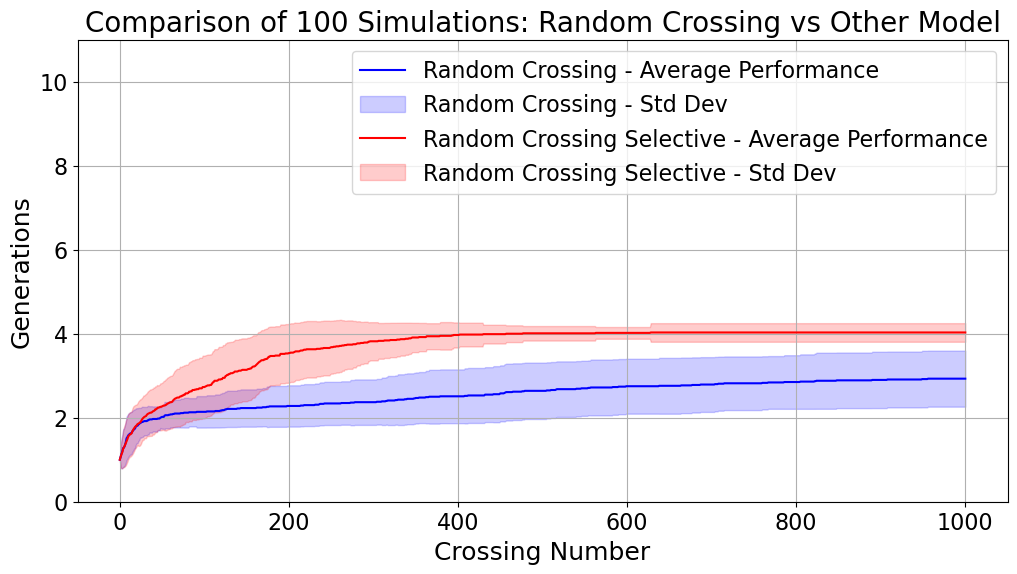

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Convert both to numpy arrays for easy aggregation
simulation_random_array = np.array(list_simulation_random)
simulation_other_array = np.array(list_simulation_better_gen)

# Calculate mean and standard deviation across simulations for both models
mean_performance_random = np.mean(simulation_random_array, axis=0)
std_performance_random = np.std(simulation_random_array, axis=0)

mean_performance_other = np.mean(simulation_other_array, axis=0)
std_performance_other = np.std(simulation_other_array, axis=0)

# Set global font sizes
plt.rcParams.update({
    'font.size': 16,          # Increase font size for all text
    'axes.titlesize': 20,     # Title font size
    'axes.labelsize': 18,     # X and Y label font size
    'xtick.labelsize': 16,    # X-axis tick label font size
    'ytick.labelsize': 16,    # Y-axis tick label font size
    'legend.fontsize': 16,    # Legend font size
    'figure.figsize': (14, 10)  # Increase the figure size
})

# Plotting the results
plt.figure(figsize=(12, 6))  # Increase the figure size

# Plot for Random Crossing model
plt.plot(mean_performance_random, label='Random Crossing - Average Performance', color='blue')
plt.fill_between(range(crosing_number + 1), 
                 mean_performance_random - std_performance_random, 
                 mean_performance_random + std_performance_random, 
                 color='blue', alpha=0.2, label='Random Crossing - Std Dev')

# Plot for Other model
plt.plot(mean_performance_other, label='Random Crossing Selective - Average Performance', color='red')
plt.fill_between(range(crosing_number + 1), 
                 mean_performance_other - std_performance_other, 
                 mean_performance_other + std_performance_other, 
                 color='red', alpha=0.2, label='Random Crossing Selective - Std Dev')

# Customize the plot
plt.title('Comparison of 100 Simulations: Random Crossing vs Other Model')
plt.xlabel('Crossing Number')
plt.ylabel('Generations')
plt.ylim(0, 11)  # Set y-axis limits from 0 to 11
plt.legend()
plt.grid(True)
plt.show()